# Market Basket Analysis 

Market Basket Analysis is one of the key techniques used by the large retailers that uncovers associations between items by looking for combinations of items that occur together frequently in transactions. In other words, it allows the retailers to identify relationships between the items that people buy.

Association Rules is widely used to analyze retail basket or transaction data, is intended to identify strong rules discovered in transaction data using some measures of interestingness, based on the concept of strong rules.

#### An Example of Association Rules


* Assume there are 100 customers
* 10 out of them bought milk, 8 bought butter and 6 bought both of them. 
* bought milk => bought butter
* Support = P(Milk & Butter) = 6/100 = 0.06
* confidence = support/P(Butter) = 0.06/0.08 = 0.75
* lift = confidence/P(Milk) = 0.75/0.10 = 7.5

## Import Libraries

In [1]:
library(tidyverse)
library(readxl)
library(knitr)
library(ggplot2)
library(lubridate)
library(arules)
library(plyr)
library(arulesViz)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'arules' was built under R version 3.6.3"Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand


Attaching package: 'arules'

The following object is masked from 'package

### Import Dataset

In [2]:
retail <- read_excel('Online Retail.xlsx')

### Data preprocessing and exploring

In [3]:
retail <- retail[complete.cases(retail), ]
retail <- retail %>% mutate(Description = as.factor(Description))
retail <- retail %>% mutate(Country = as.factor(Country))
retail$Date <- as.Date(retail$InvoiceDate)
retail$Time <- format(retail$InvoiceDate,"%H:%M:%S")
retail$InvoiceNo <- as.numeric(as.character(retail$InvoiceNo))

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

**glimpse()** is like a transposed version of print() : columns run down the page, and data runs across. This makes it possible to see every column in a data frame. It's a little like str() applied to a data frame but it tries to show you as much data as possible.

In [5]:
glimpse(retail)
str(retail)

Observations: 406,829
Variables: 10
$ InvoiceNo   <dbl> 536365, 536365, 536365, 536365, 536365, 536365, 536365,...
$ StockCode   <chr> "85123A", "71053", "84406B", "84029G", "84029E", "22752...
$ Description <fct> WHITE HANGING HEART T-LIGHT HOLDER, WHITE METAL LANTERN...
$ Quantity    <dbl> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, ...
$ InvoiceDate <dttm> 2010-12-01 08:26:00, 2010-12-01 08:26:00, 2010-12-01 0...
$ UnitPrice   <dbl> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1...
$ CustomerID  <dbl> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850,...
$ Country     <fct> United Kingdom, United Kingdom, United Kingdom, United ...
$ Date        <date> 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-01, 2010-1...
$ Time        <chr> "08:26:00", "08:26:00", "08:26:00", "08:26:00", "08:26:...
Classes 'tbl_df', 'tbl' and 'data.frame':	406829 obs. of  10 variables:
 $ InvoiceNo  : num  536365 536365 536365 536365 536365 ...
 $ StockCode  : chr  "85123A" "71053" "844

### What time do people often purchase online?

In order to find the answer to this question, we need to extract "hour" from the time column.

In [6]:
retail$Time <- as.factor(retail$Time)
a <- hms(as.character(retail$Time))
retail$Time = hour(a)

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

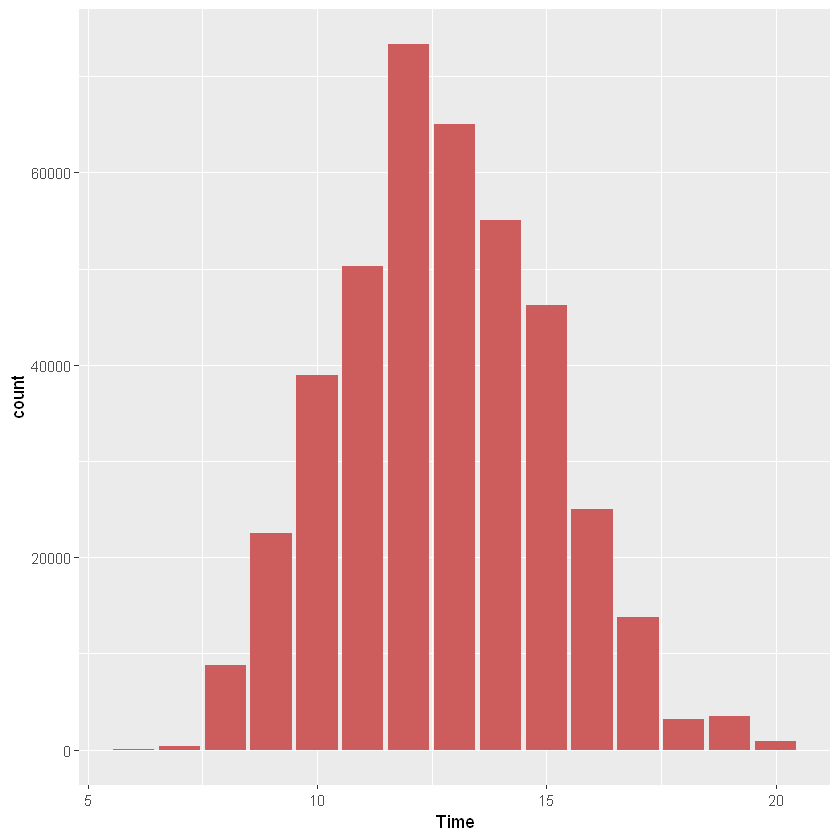

In [7]:
retail %>% 
  ggplot(aes(x=Time)) + 
  geom_histogram(stat="count",fill="indianred")

There is a clear effect of hour of day on order volume. Most orders happened between 11:00-15:00.

In [8]:
detach("package:plyr", unload=TRUE)

Warning message:
"'plyr' namespace cannot be unloaded:
  namespace 'plyr' is imported by 'ggplot2' so cannot be unloaded"

The attach function allows to access variables of a data.frame without calling the data.frame.

The detach function can be used to:

* Remove the attachment of a data.frame, which was previously attached with the attach function.
* Unload a package, which was previously loaded with the library function.

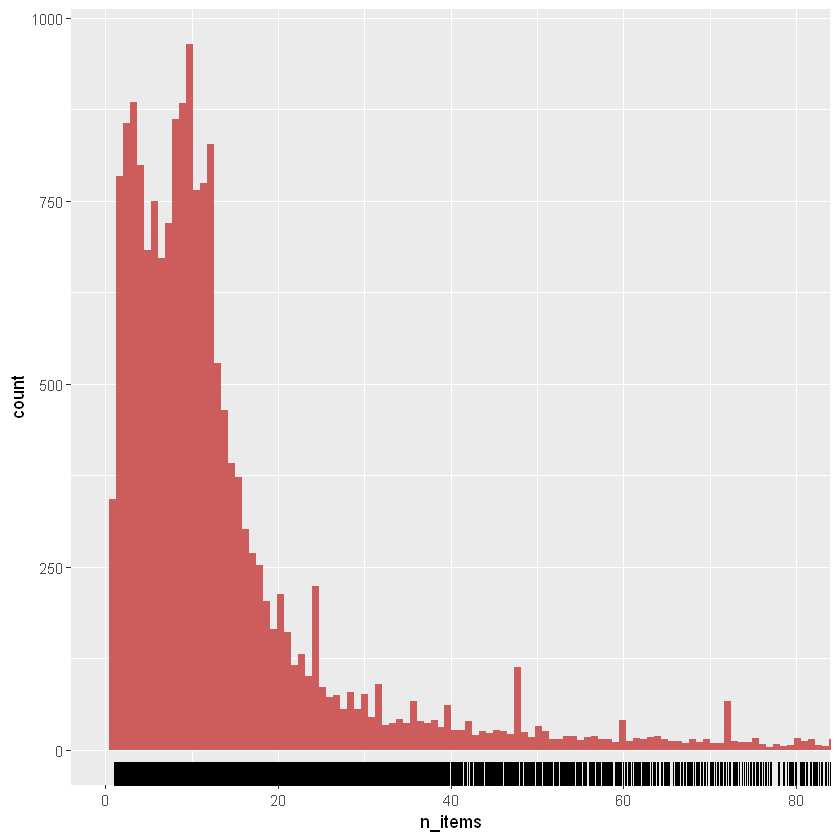

In [9]:
retail %>% 
  group_by(InvoiceNo) %>% 
  summarize(n_items = mean(Quantity)) %>%
  ggplot(aes(x=n_items))+
  geom_histogram(fill="indianred", bins = 100000) + 
  geom_rug()+
  coord_cartesian(xlim=c(0,80))

* group_by <- group one or more variables
* geom_rug() <-  relationship between 2 numeric variables
* summarize <- summarize is a fast version of summary. formula(formula,  method="cross",overall=FALSE) for producing stratified summary statistics and storing them in a data frame for plotting 

# Top 10 best sellers

In [10]:
tmp <- retail %>% 
  group_by(StockCode, Description) %>% 
  summarize(count = n()) %>% 
  arrange(desc(count))
tmp <- head(tmp, n=10)
tmp

StockCode,Description,count
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2070
22423,REGENCY CAKESTAND 3 TIER,1905
85099B,JUMBO BAG RED RETROSPOT,1662
84879,ASSORTED COLOUR BIRD ORNAMENT,1418
47566,PARTY BUNTING,1416
20725,LUNCH BAG RED RETROSPOT,1358
22720,SET OF 3 CAKE TINS PANTRY DESIGN,1232
POST,POSTAGE,1196
20727,LUNCH BAG BLACK SKULL.,1126
21212,PACK OF 72 RETROSPOT CAKE CASES,1080


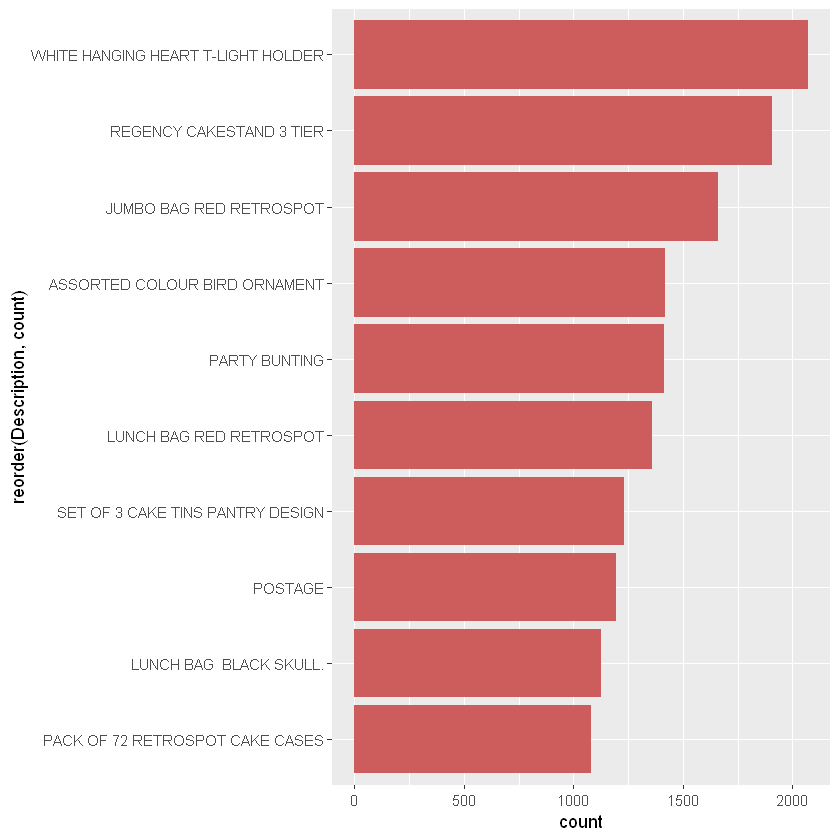

In [11]:
tmp %>% 
  ggplot(aes(x=reorder(Description,count), y=count))+
  geom_bar(stat="identity",fill="indian red")+
  coord_flip()

## Association rules for online retailer

Before using any rule mining algorithm, we need to transform data from the data frame format into transactions such that we have all the items bought together in one row. For example, this is the format we need:

In [12]:
retail_sorted <- retail[order(retail$CustomerID),]
library(plyr)
itemList <- ddply(retail,c("CustomerID","Date"), 
                       function(df1)paste(df1$Description, 
                       collapse = ","))

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following object is masked from 'package:lubridate':

    here

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from 'package:purrr':

    compact



**paste()** paste converts its arguments (via as.character ) to character strings, and concatenates them

The function ddply() accepts a data frame, splits it into pieces based on one or more factors, computes on the pieces, then returns the results as a data frame. We use "," to separate different items. 

We only need item transactions, so, remove customerID and Date columns

In [13]:
itemList$CustomerID <- NULL
itemList$Date <- NULL
colnames(itemList) <- c("items")

Write the data from to a csv file and check whether our transaction format is correct. 

In [14]:
write.csv(itemList,"market_basket1.csv", quote = FALSE, row.names = TRUE)


Perfect! Now we have our transaction dataset shows the matrix of items being bought together. We don't actually see how often they are bought together, we don't see rules either. But we are going to find out. 

Let's have a closer look how many transaction we have and what they are.

In [15]:
print('Description of the transactions')
tr <- read.transactions('market_basket1.csv', format = 'basket', sep=',')
tr
summary(tr)

[1] "Description of the transactions"


Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
"EOF within quoted string"Wa

transactions in sparse format with
 19297 transactions (rows) and
 27165 items (columns)

transactions as itemMatrix in sparse format with
 19297 rows (elements/itemsets/transactions) and
 27165 columns (items) and a density of 0.0006701659 

most frequent items:
WHITE HANGING HEART T-LIGHT HOLDER           REGENCY CAKESTAND 3 TIER 
                              1758                               1660 
           JUMBO BAG RED RETROSPOT                      PARTY BUNTING 
                              1434                               1271 
     ASSORTED COLOUR BIRD ORNAMENT                            (Other) 
                              1237                             343943 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   1 2263 1189  851  768  725  662  618  597  582  554  572  506  487  508  504 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 503  449  413  477  420  383  304  313  270  237  253  223  204  222  216  171 
  33   34   35   3

The summary gives us some useful information:

* density: The percentage of non-empty cells in the sparse matrix. In another word, the total number of items that purchased divided by the total number of possible items in that matrix. We can calculate how many items were purchased using density like so: 

19296 X 7881 X 0.0022

* The most frequent items should be same with our results in Figure 3.

* For the sizes of the transactions, 2247 transactions for just 1 items, 1147 transactions for 2 items, all the way up to the biggest transaction: 1 transaction for 420 items. This indicates that most customers buy small number of items on each purchase.

* The data distribution is right skewed.

Let's have a look item freqnency plot, this should be in align with Figure 3.

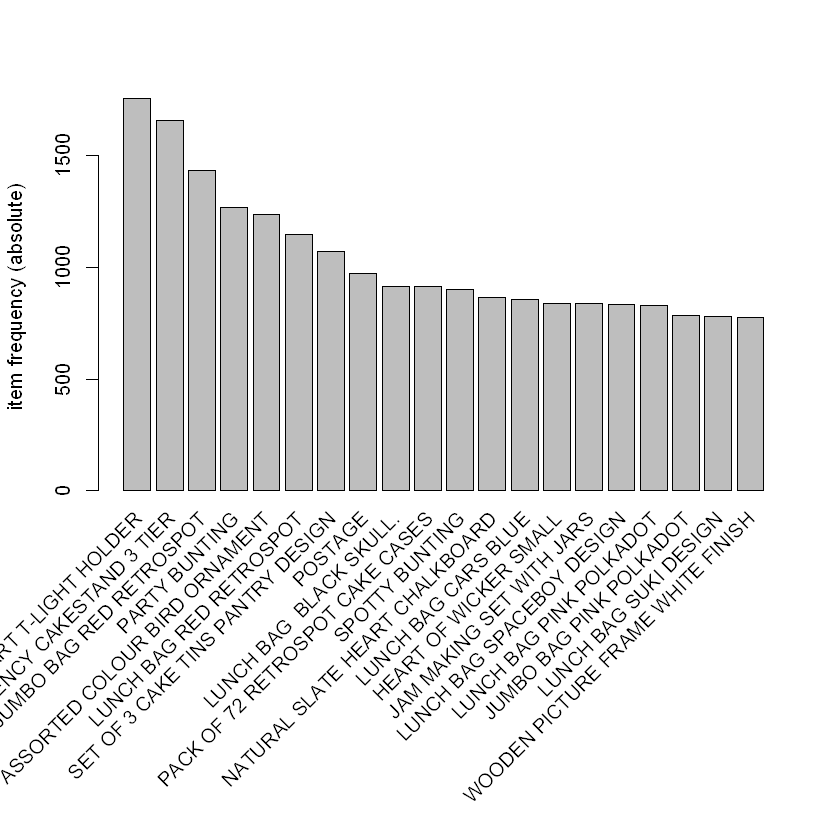

In [16]:
itemFrequencyPlot(tr, topN=20, type='absolute')

### Create some rules

* We use the Apriori algorithm in arules library to mine frequent itemsets and association rules. The algorithm employs level-wise search for frequent itemsets.

* We pass supp=0.001 and conf=0.8 to return all the rules have a support of at least 0.1% and confidence of at least 80%. 

* We sort the rules by decreasing confidence. 

* Have a look the summary of the rules. 

In [17]:
rules <- apriori(tr, parameter = list(supp=0.001, conf=0.8))
rules <- sort(rules, by='confidence', decreasing = TRUE)
summary(rules)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5   0.001      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 19 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[27165 item(s), 19297 transaction(s)] done [0.17s].
sorting and recoding items ... [2407 item(s)] done [0.00s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10

Warning message in apriori(tr, parameter = list(supp = 0.001, conf = 0.8)):
"Mining stopped (maxlen reached). Only patterns up to a length of 10 returned!"

 done [0.44s].
writing ... [87110 rule(s)] done [0.05s].
creating S4 object  ... done [0.06s].


set of 87110 rules

rule length distribution (lhs + rhs):sizes
    2     3     4     5     6     7     8     9    10 
  105  3133  9732 26228 29873 14020  3218   680   121 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   5.000   6.000   5.627   6.000  10.000 

summary of quality measures:
    support           confidence        coverage             lift        
 Min.   :0.001036   Min.   :0.8000   Min.   :0.001036   Min.   :  8.781  
 1st Qu.:0.001088   1st Qu.:0.8333   1st Qu.:0.001244   1st Qu.: 19.305  
 Median :0.001192   Median :0.8750   Median :0.001399   Median : 24.786  
 Mean   :0.001383   Mean   :0.8834   Mean   :0.001572   Mean   : 50.921  
 3rd Qu.:0.001503   3rd Qu.:0.9231   3rd Qu.:0.001658   3rd Qu.: 43.662  
 Max.   :0.018086   Max.   :1.0000   Max.   :0.021765   Max.   :622.484  
     count       
 Min.   : 20.00  
 1st Qu.: 21.00  
 Median : 23.00  
 Mean   : 26.69  
 3rd Qu.: 29.00  
 Max.   :349.00  

mining info:
 data ntransactions support confidence
 

* The number of rules: 89,697.
* The distribution of rules by length: Most rules are 6 items long.
* The summary of quality measures: ranges of support, confidence, and lift.
* The information on the data mining: total data mined, and minimum parameters we set earlier.

In [18]:
inspect(rules[1:10])

     lhs                         rhs             support     confidence
[1]  {WOBBLY CHICKEN}         => {DECORATION}    0.001451003 1         
[2]  {WOBBLY CHICKEN}         => {METAL}         0.001451003 1         
[3]  {DECOUPAGE}              => {GREETING CARD} 0.001191895 1         
[4]  {BILLBOARD FONTS DESIGN} => {WRAP}          0.001502824 1         
[5]  {WOBBLY RABBIT}          => {DECORATION}    0.001761932 1         
[6]  {WOBBLY RABBIT}          => {METAL}         0.001761932 1         
[7]  {BLACK TEA}              => {SUGAR JARS}    0.002331969 1         
[8]  {BLACK TEA}              => {COFFEE}        0.002331969 1         
[9]  {ART LIGHTS}             => {FUNK MONKEY}   0.001969218 1         
[10] {FUNK MONKEY}            => {ART LIGHTS}    0.001969218 1         
     coverage    lift      count
[1]  0.001451003 385.94000 28   
[2]  0.001451003 385.94000 28   
[3]  0.001191895 344.58929 23   
[4]  0.001502824 622.48387 29   
[5]  0.001761932 385.94000 34   
[6]  0.001


* 100% customers who bought "WOBBLY CHICKEN" end up bought "DECORATION" as well. 

* 100% customers who bought "BLACK TEA" end up bought "SUGAR JAR" as well.

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


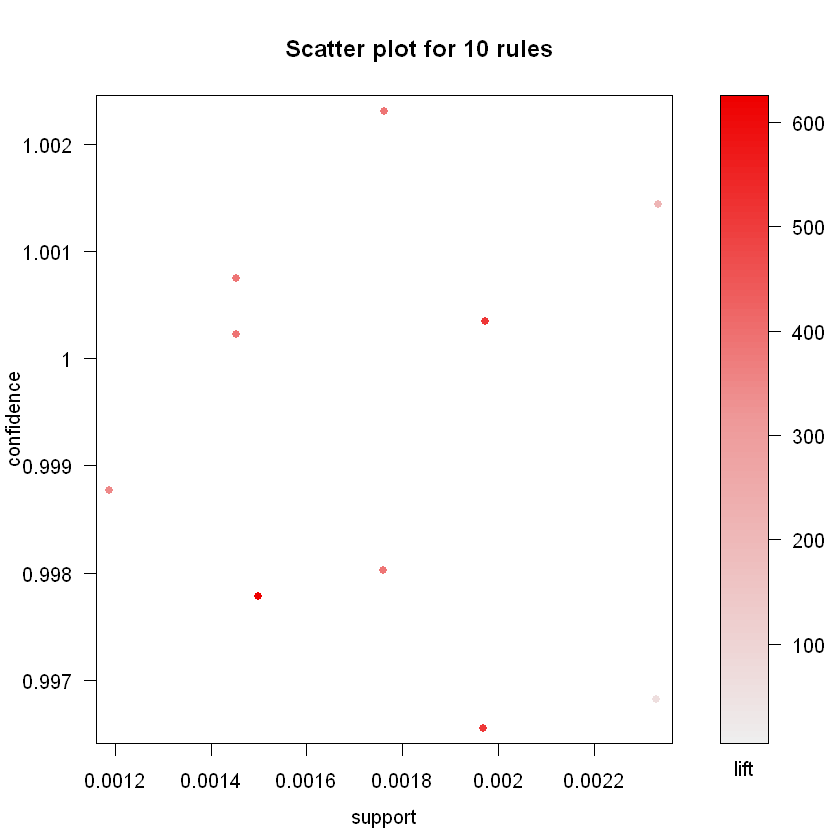

In [19]:
topRules <- rules[1:10]
plot(topRules)

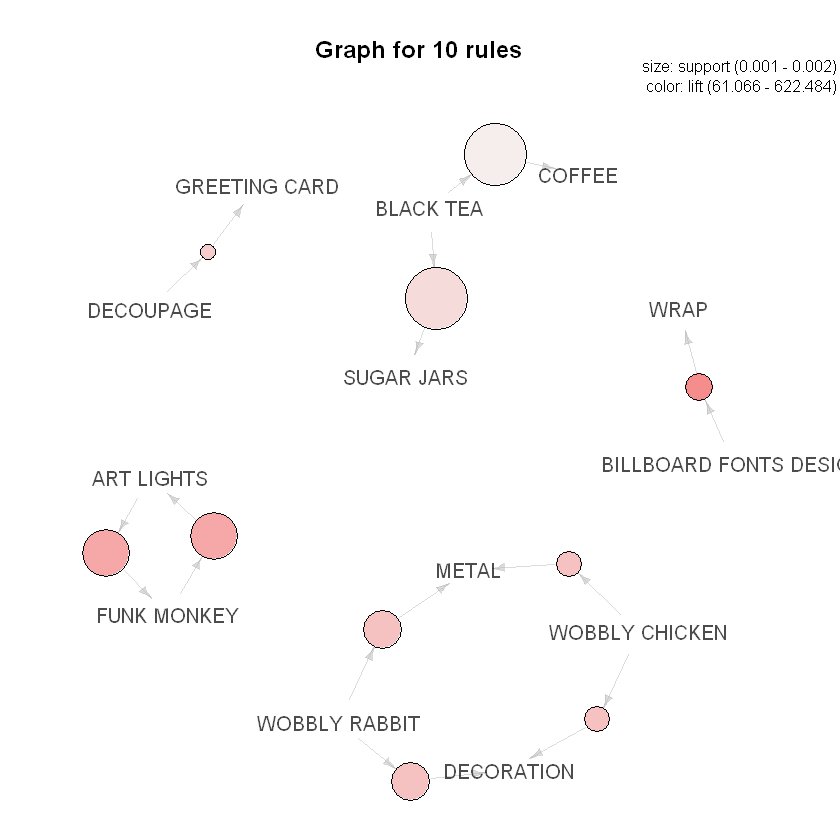

In [20]:
plot(topRules, method="graph")

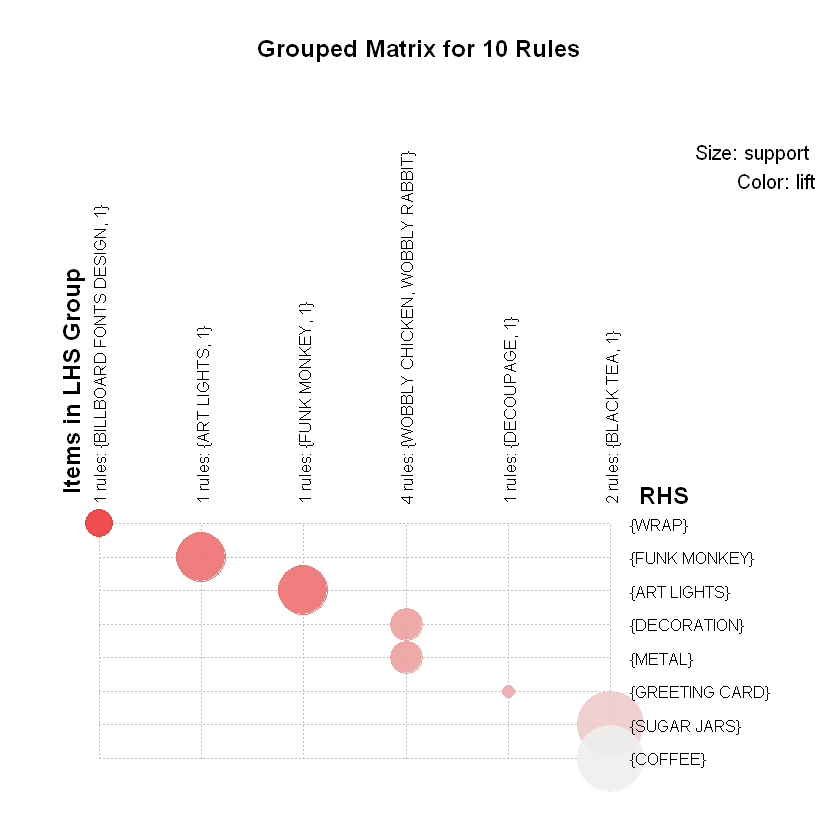

In [21]:
plot(topRules, method = "grouped")